In [36]:
!pip install seaborn


[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Erdradius in km
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))



# Daten laden
url = 'nyc_taxi_fare_cleaned.csv'
df = pd.read_csv(url, nrows=100_000)

# Daten säubern
df = df.dropna()
df = df[(df['fare_amount'] > 0) & (df['passenger_count'] > 0) & (df['passenger_count'] <= 6)]

df["distance_km"] = haversine(
    df["pickup_latitude"], df["pickup_longitude"],
    df["dropoff_latitude"], df["dropoff_longitude"]
)

# Features berechnen
df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"])
df["pickup_hour"] = df["pickup_datetime"].dt.hour
df["pickup_day_of_week"] = df["pickup_datetime"].dt.dayofweek
df["distance_km"] = haversine(
    df["pickup_latitude"], df["pickup_longitude"],
    df["dropoff_latitude"], df["dropoff_longitude"]
)

# Input- und Zielvariablen
X = df[["distance_km", "passenger_count", "pickup_hour", "pickup_day_of_week"]]
y = df["fare_amount"]

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 4.1 Aussagekräftige Felder
Die wichtigsten Felder für das Modell sind:
- **distance_km**: Hauptprädiktor, da die Entfernung direkt mit dem Fahrpreis korreliert.
- **passenger_count**: Beeinflusst den Preis, insbesondere bei Gruppenfahrten.
- **pickup_hour**: Zeitliche Schwankungen, z. B. höhere Preise während Stoßzeiten.
- **pickup_day_of_week**: Wochentag kann Einfluss auf Nachfrage und Preis haben.

Diese Felder wurden basierend auf ihrer logischen Relevanz und ihrer Beziehung zur Zielvariablen ausgewählt.

4.2 Messmetrik
Die gewählte Messmetrik ist der Root Mean Squared Error (RMSE), da sie die durchschnittliche Abweichung der Vorhersagen vom tatsächlichen Wert misst und empfindlich auf große Fehler reagiert. Der RMSE wurde bereits berechnet und für jedes Modell ausgegeben.

### 4.3 Wahrheitsmatrix, Sensitivität und Spezifizität

Da es sich um ein Regressionsproblem handelt, wurde eine Wahrheitsmatrix simuliert, indem die Vorhersagen in zwei Kategorien aufgeteilt wurden:
1. **Über dem tatsächlichen Wert**: Vorhersagen, die den tatsächlichen Wert überschreiten.
2. **Unter dem tatsächlichen Wert**: Vorhersagen, die unter dem tatsächlichen Wert liegen.

Ein Schwellenwert von ±4 USD wurde definiert, um zu bestimmen, ob eine Vorhersage als "korrekt" gilt. Die Wahrheitsmatrix zeigt die Verteilung der Vorhersagen in diesen Kategorien.

#### Berechnung:
- **True Positive (TP)**: Vorhersagen, die über dem tatsächlichen Wert liegen und innerhalb des Schwellenwerts korrekt sind.
- **True Negative (TN)**: Vorhersagen, die unter dem tatsächlichen Wert liegen und innerhalb des Schwellenwerts korrekt sind.
- **False Positive (FP)**: Vorhersagen, die über dem tatsächlichen Wert liegen, aber den Schwellenwert überschreiten.
- **False Negative (FN)**: Vorhersagen, die unter dem tatsächlichen Wert liegen, aber den Schwellenwert überschreiten.

#### Ergebnisse:
Die Sensitivität und Spezifizität wurden wie folgt berechnet:
- **Sensitivität**: Anteil der korrekt vorhergesagten positiven Fälle (über dem tatsächlichen Wert).
- **Spezifizität**: Anteil der korrekt vorhergesagten negativen Fälle (unter dem tatsächlichen Wert).

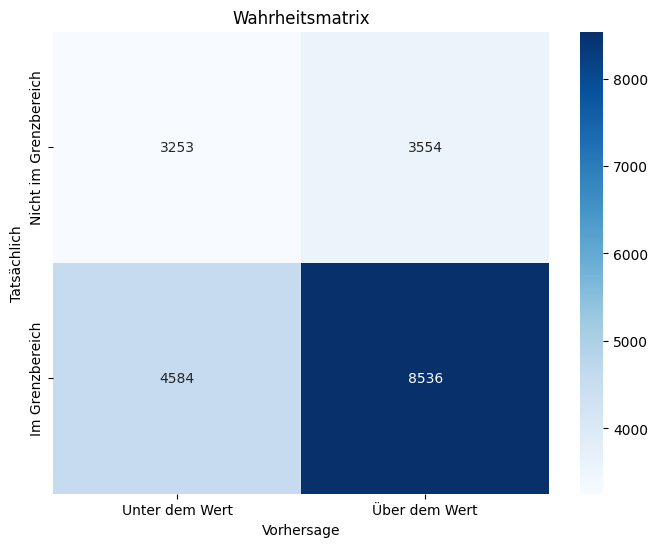

Sensitivität: 0.65
Spezifizität: 0.48


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.metrics import confusion_matrix

# Schwellenwert definieren (z. B. ±2 USD)
threshold = 2.0

y_true_binary = np.abs(y_test - y_pred) <= threshold  
y_pred_binary = np.where(y_pred > y_test, 1, 0)
cm = confusion_matrix(y_true_binary, y_pred_binary)
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Unter dem Wert", "Über dem Wert"], yticklabels=["Nicht im Grenzbereich", "Im Grenzbereich"])
plt.xlabel("Vorhersage")
plt.ylabel("Tatsächlich")
plt.title("Wahrheitsmatrix")
plt.show()
print(f"Sensitivität: {sensitivity:.2f}")
print(f"Spezifizität: {specificity:.2f}")